In [31]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [32]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [33]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [34]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [35]:
df

,Date,Close,EFFR
0,2014-01-02,30.055000,0.08
1,2014-01-03,30.035000,0.08
2,2014-01-06,30.160000,0.08
3,2014-01-07,30.260000,0.07
4,2014-01-08,30.150000,0.07
...,...,...,...
1504,2019-12-23,39.160000,1.55
1505,2019-12-24,39.290001,1.55
1506,2019-12-26,39.389999,1.55
1507,2019-12-27,39.419998,1.55


In [36]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055000,0.0008,3.174603e-08
1,2014-01-03,30.035000,0.0008,3.174603e-08
2,2014-01-06,30.160000,0.0008,3.174603e-08
3,2014-01-07,30.260000,0.0007,2.777778e-08
4,2014-01-08,30.150000,0.0007,2.777778e-08
...,...,...,...,...
1504,2019-12-23,39.160000,0.0155,6.150794e-07
1505,2019-12-24,39.290001,0.0155,6.150794e-07
1506,2019-12-26,39.389999,0.0155,6.150794e-07
1507,2019-12-27,39.419998,0.0155,6.150794e-07


In [37]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

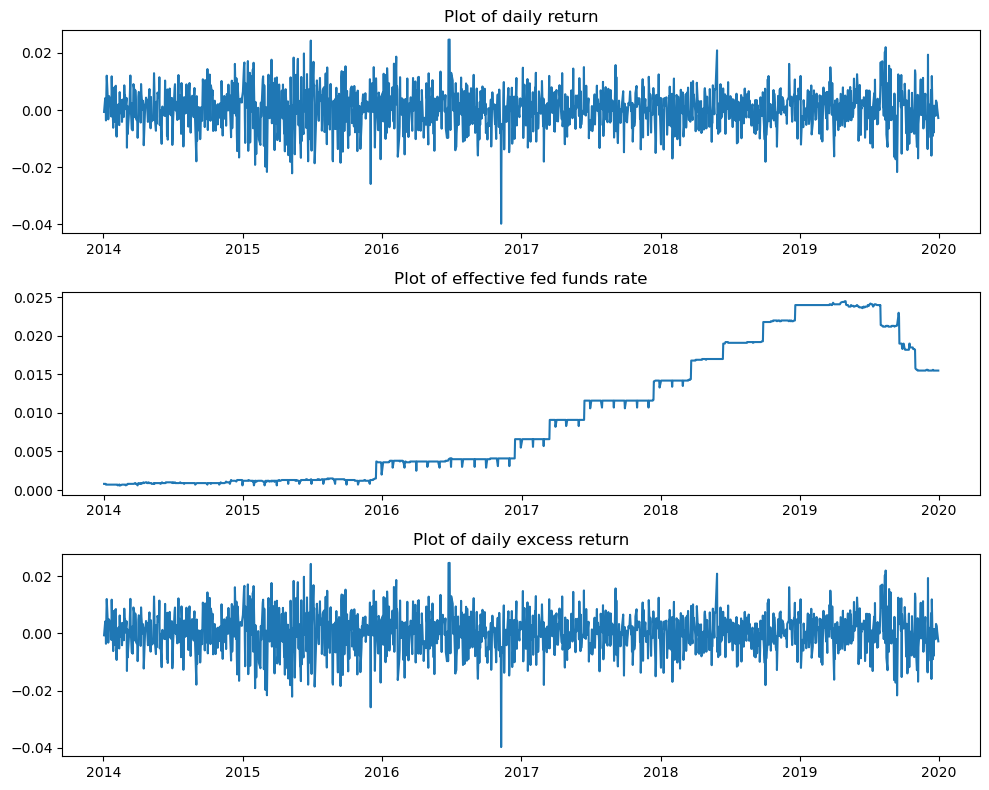

In [38]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[0].set_title('Plot of daily return')
ax[1].plot(df['Date'], df['EFFR'])
ax[1].set_title('Plot of effective fed funds rate')
ax[2].plot(df['Date'], df['Daily_excess_return'])
ax[2].set_title('Plot of daily excess return')
plt.tight_layout()

## 2. Trading Strategies

### Strategy: LSTM Strategy

In [39]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [40]:
df['ema12'] = df['Close'].ewm(span = 12).mean()
df['ema26'] = df['Close'].ewm(span = 26).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span = 9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

In [41]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,ema12,ema26,macd,macd_signal,macd_hist
0,2014-01-02,30.055000,0.0008,3.174603e-08,NaN,NaN,NaN,30.055000,30.055000,0.000000,0.000000,0.000000
1,2014-01-03,30.035000,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,30.044167,30.044615,-0.000449,-0.000249,-0.000199
2,2014-01-06,30.160000,0.0008,3.174603e-08,0.004162,0.004162,0.041618,30.089376,30.086072,0.003304,0.001207,0.002097
3,2014-01-07,30.260000,0.0007,2.777778e-08,0.003316,0.003316,0.033156,30.143236,30.134695,0.008541,0.003692,0.004849
4,2014-01-08,30.150000,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,30.145073,30.138244,0.006829,0.004625,0.002204
...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,0.0155,6.150794e-07,-0.002039,-0.002039,-0.020394,39.514002,39.703280,-0.189278,-0.106898,-0.082380
1505,2019-12-24,39.290001,0.0155,6.150794e-07,0.003320,0.003319,0.033191,39.479540,39.672667,-0.193127,-0.124144,-0.068983
1506,2019-12-26,39.389999,0.0155,6.150794e-07,0.002545,0.002545,0.025445,39.465765,39.651728,-0.185964,-0.136508,-0.049456
1507,2019-12-27,39.419998,0.0155,6.150794e-07,0.000762,0.000761,0.007610,39.458724,39.634563,-0.175840,-0.144374,-0.031465


<BarContainer object of 1509 artists>

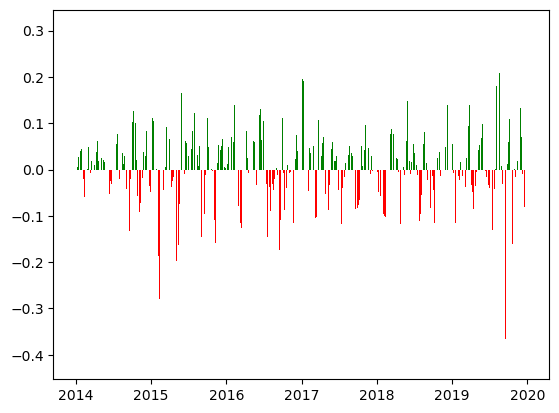

In [42]:
color = np.where(df['macd_hist'] >= 0, 'green', 'red')

# plt.plot(df['Date'], df['macd'], label = 'MACD')
# plt.plot(df['Date'], df['macd_signal'], label = 'Signal')
plt.bar(df['Date'], df['macd_hist'], color = color)

In [43]:
df = df.dropna()
regime = [0]
macd_hist = np.array(df['macd_hist'])
for i in range(1, len(macd_hist)):
    if macd_hist[i] > 0 and macd_hist[i-1] <= 0:
        regime.append(1)
    elif macd_hist[i] < 0 and macd_hist[i-1] >= 0:
        regime.append(-1)
    else:
        regime.append(0)

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


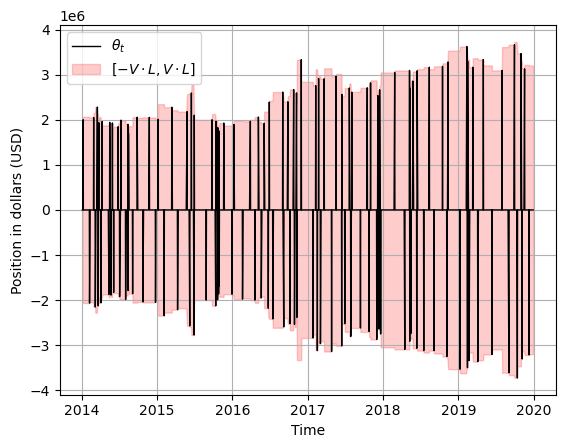

In [44]:

result = compute_position_value(df = df, signal = np.array(regime), initial_capital = INITIAL_CAP, leverage = LEVERAGE)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_10522/88176204.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_PnL(df['Date'][1:], result['V'], result['Vcap'], result['Vtot'])
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/plotting_computation.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


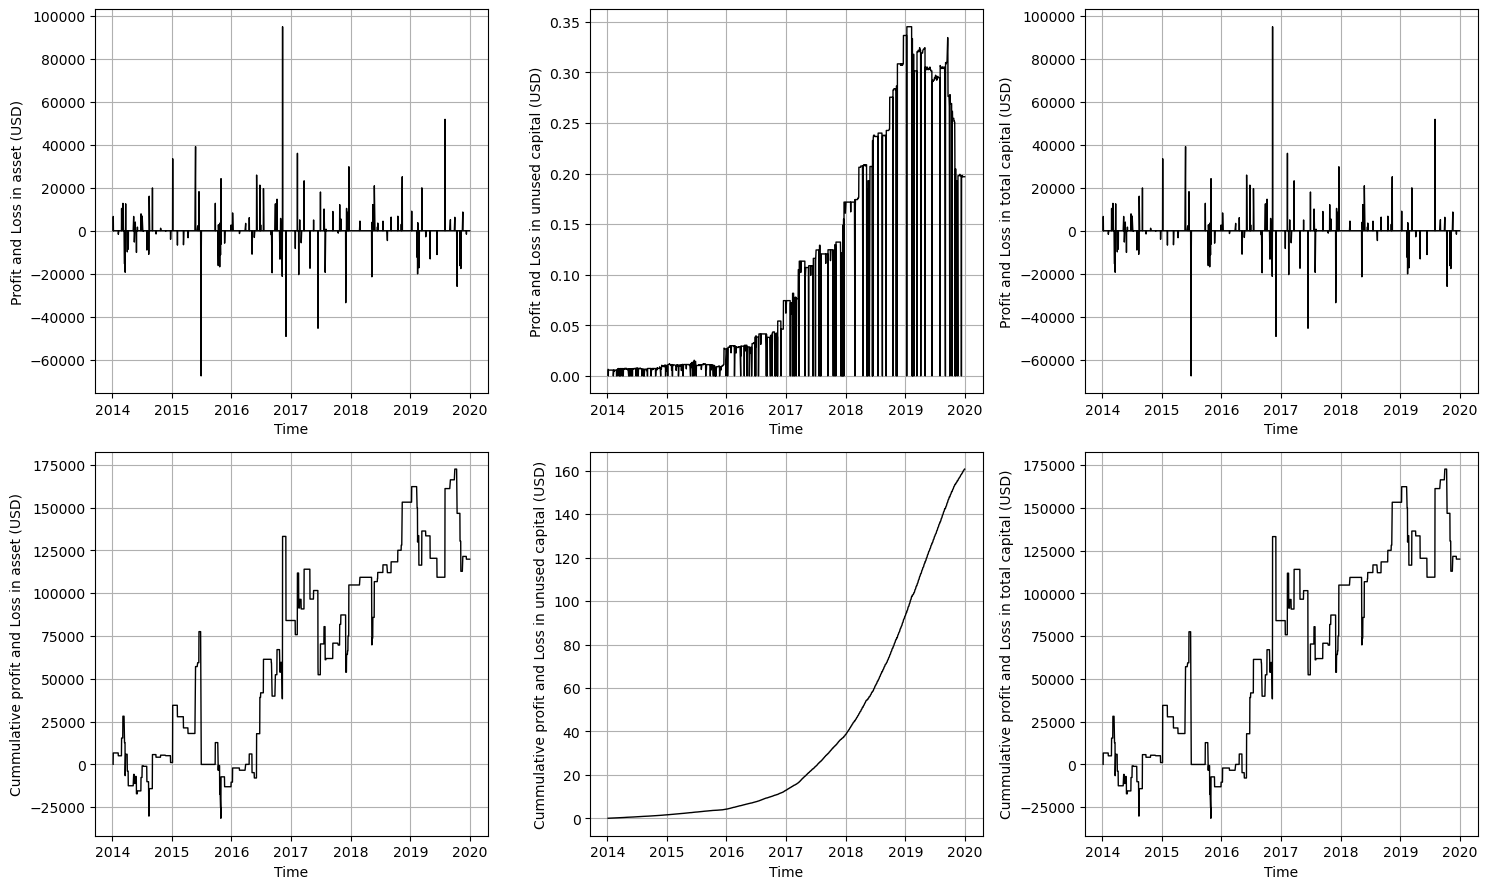

In [45]:
plot_PnL(df['Date'][1:], result['V'], result['Vcap'], result['Vtot'])
